In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../WNTR_Model/')
from testWN import testWN as twm

import tensorflow as tf
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = (10,6)

# Data Preprocessing:

In [4]:
file = './data/surrModel_trainingDB_uF0_PS1_ss100k.pkl'
with open(file, 'rb') as f:
    train_data = pickle.load(f)
training_in = train_data['input']
training_out = train_data['output']

In [5]:
input_names = {}
input_names_raw = training_in.keys().to_list()

output_names = {}
output_names_raw = training_out.keys().to_list()

input_names['demand'] = [name_i for name_i in input_names_raw if name_i.startswith('J')]
input_names['pumps'] = [name_i for name_i in input_names_raw if name_i.startswith('PU')]
input_names['valves'] = [name_i for name_i in input_names_raw if name_i.startswith('V')]
input_names['tanks'] = [name_i for name_i in input_names_raw if name_i.startswith('T')]

output_names['pressure'] = [name_i for name_i in output_names_raw if name_i.startswith('J')]
output_names['tanks'] = [name_i for name_i in output_names_raw if name_i.startswith('T')]
output_names['power'] = [name_i for name_i in output_names_raw if name_i.startswith('PU')]

## Check Data and filter

``data_filter`` holds a ``bool`` for every entry of the data matrices. It is set to zero if any of the conditions are not satisfied. All data is filtered in the end to exclude faulty values.

In [6]:
data_filter = np.ones(training_in.shape[0], dtype=bool)

### Junctions:
Pressure and demand.

In [7]:
junction_demand = training_in[input_names['demand']]
junction_pressure = training_out[output_names['pressure']]

<AxesSubplot:title={'center':'pressure'}, xlabel='time [h]', ylabel='pressure [m]'>

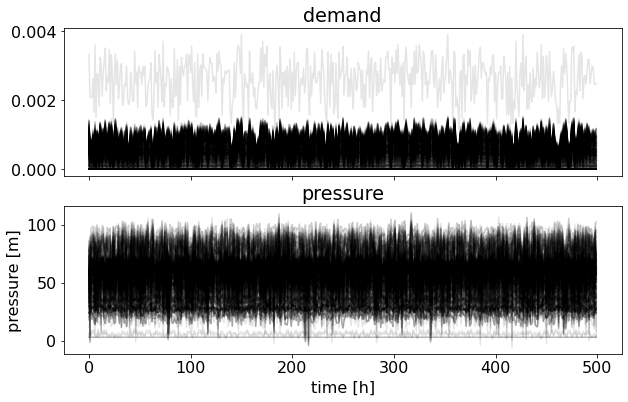

In [8]:
fig, ax = plt.subplots(2,1, sharex=True)
junction_demand.head(500).plot(ax=ax[0],legend=False, color='k', alpha=0.1, title='demand', xlabel='time [h]')
junction_pressure.head(500).plot(ax=ax[1],legend=False, color='k', alpha=0.1, title='pressure', xlabel='time [h]', ylabel='pressure [m]')

In [9]:
#data_filter = data_filter & np.all(np.abs(junction_pressure)<1e3, axis=1)
#data_filter = data_filter & np.all(junction_pressure>0, axis=1)

After filtering:

<AxesSubplot:title={'center':'pressure'}, xlabel='time [h]', ylabel='pressure [m]'>

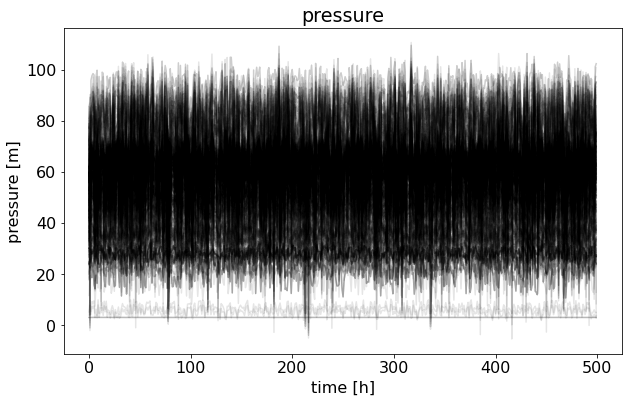

In [10]:
junction_pressure[data_filter].head(500).plot(legend=False, color='k', alpha=0.1, title='pressure', xlabel='time [h]', ylabel='pressure [m]')

### Tank levels:

<AxesSubplot:title={'center':'next tank levels'}, xlabel='time [h]', ylabel='delta height [m]'>

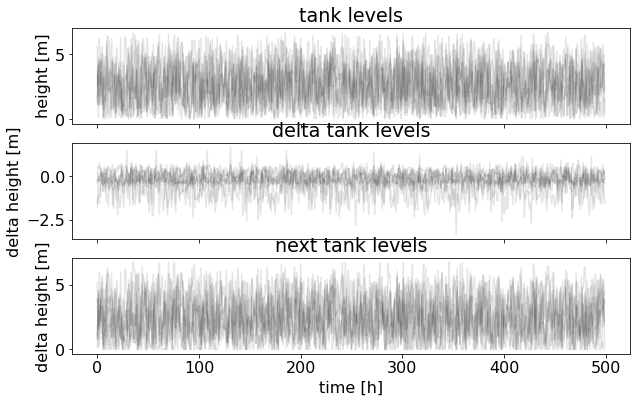

In [11]:
fig, ax = plt.subplots(3,1, sharex = True)
tank_level = training_in[input_names['tanks']]
dtank_level = training_out[output_names['tanks']]
dtank_level.columns = tank_level.columns
tank_level_next = tank_level+dtank_level
tank_level.head(500).plot(ax=ax[0],legend=False, color='k', alpha=0.1, title='tank levels', xlabel='time [h]', ylabel='height [m]')
dtank_level.head(500).plot(ax=ax[1],legend=False, color='k', alpha=0.1, title='delta tank levels', xlabel='time [h]', ylabel='delta height [m]')
tank_level_next.head(500).plot(ax=ax[2],legend=False, color='k', alpha=0.1, title='next tank levels', xlabel='time [h]', ylabel='delta height [m]')

In [12]:
100*(tank_level_next.mean()-tank_level.mean())/tank_level.mean()

T3    -1.690607
T1    -8.239207
T7   -27.415509
T6    -2.852221
T5    -8.000860
T2     7.004937
T4   -30.743406
dtype: float64

### Pumps:

<AxesSubplot:title={'center':'pump setting'}, xlabel='time [h]', ylabel='setting'>

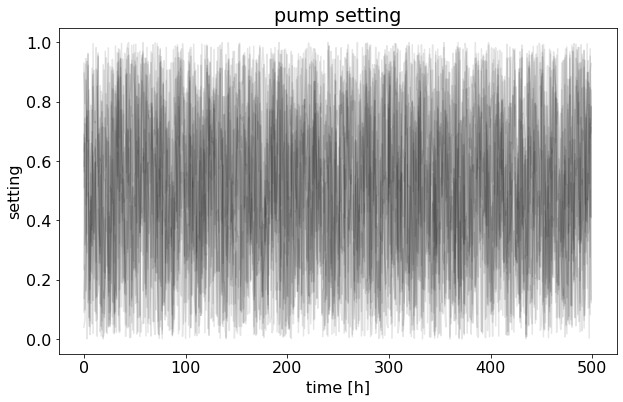

In [13]:
pump_setting = training_in[input_names['pumps']]
pump_setting.head(500).plot(legend=False, color='k', alpha=0.1, title='pump setting', xlabel='time [h]', ylabel='setting')

<AxesSubplot:title={'center':'pump power'}, xlabel='time [h]', ylabel='power'>

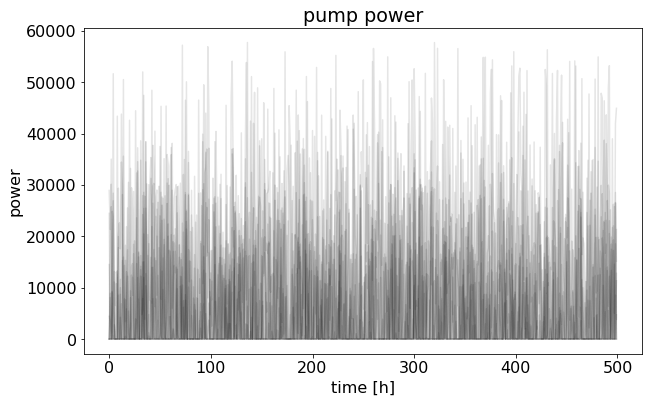

In [14]:
pump_power = training_out[output_names['power']]
pump_power.head(500).plot(legend=False, color='k', alpha=0.1, title='pump power', xlabel='time [h]', ylabel='power')

In [15]:
#data_filter = data_filter & np.all(np.abs(pump_power)<1e6,axis=1) & np.all(pump_power>=0, axis=1)

After filtering:

<AxesSubplot:title={'center':'pump power'}, xlabel='time [h]', ylabel='power'>

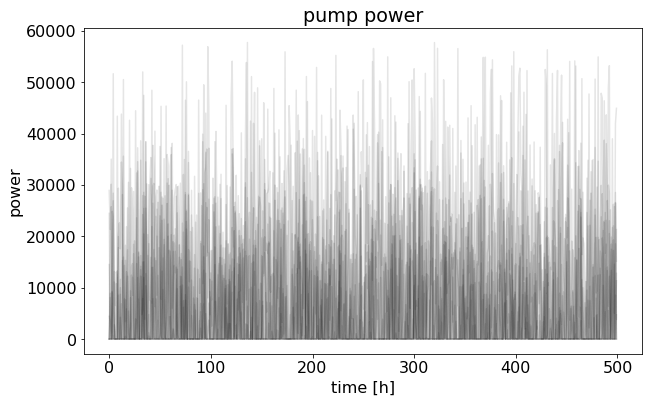

In [16]:
pump_power[data_filter].head(500).plot(legend=False, color='k', alpha=0.1, title='pump power', xlabel='time [h]', ylabel='power')

Let's check the pump_power vs pump_setting after filtering:

Text(0.5, 1.0, 'pump setting vs. power consumption')

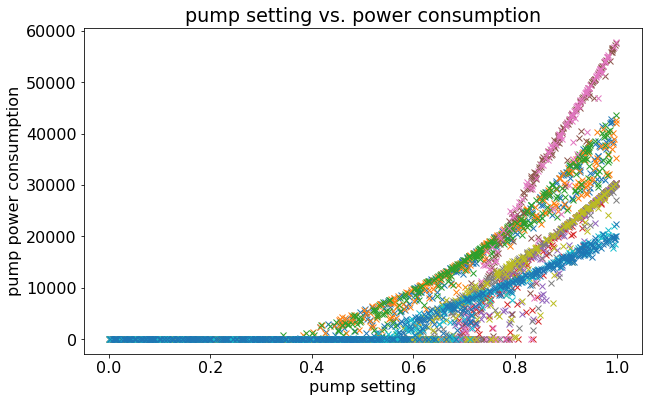

In [17]:
fig, ax = plt.subplots()
ax.plot(pump_setting[data_filter].head(500).to_numpy(), pump_power[data_filter].head(500).to_numpy(), 'x')
ax.set_xlabel('pump setting')
ax.set_ylabel('pump power consumption')
ax.set_title('pump setting vs. power consumption')

### Valves

<AxesSubplot:title={'center':'valve settting'}, xlabel='time [h]', ylabel='setting'>

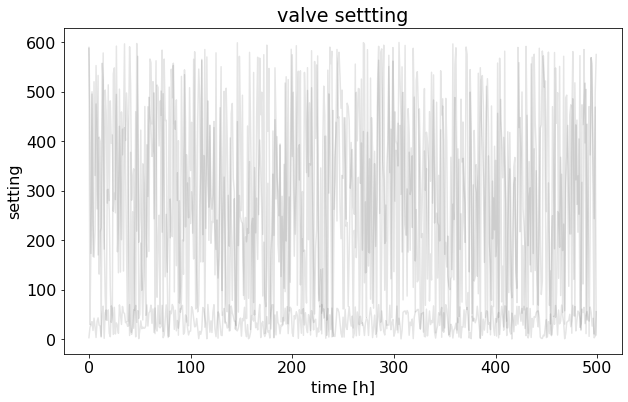

In [18]:
valve_setting = training_in[input_names['valves']]

valve_setting.head(500).plot(legend=False, color='k', alpha=0.1, title='valve settting', xlabel='time [h]', ylabel='setting')

## Neural Network Pre-Processing
### NN inputs:

In [19]:
input_1_dict = {
    'junction_demand': junction_demand[data_filter]
}
nn_inputs_1 = pd.concat(input_1_dict.values(), axis=1, keys=input_1_dict.keys())

input_2_dict = {
    'tank_level': tank_level[data_filter],
}
nn_inputs_2 = pd.concat(input_2_dict.values(), axis=1, keys=input_2_dict.keys())

input_3_dict = {
    'pump_setting': pump_setting[data_filter],                   
    'valve_setting': valve_setting[data_filter]
}
nn_inputs_3 = pd.concat(input_3_dict.values(), axis=1, keys=input_3_dict.keys())

nn_input_dict = {
    'demand': nn_inputs_1,
    'states': nn_inputs_2,
    'inputs': nn_inputs_3,
}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

nn_input.head(2)

demand                                                            \
  junction_demand                                                             
           J511_d    J411_d    J414_d J415_d J416_d    J417_d J418_d J419_d   
0        0.000929  0.000762  0.000828    0.0    0.0  0.001107    0.0    0.0   
1        0.000587  0.000412  0.000447    0.0    0.0  0.000598    0.0    0.0   

                       ...       inputs                                \
                       ... pump_setting                                 
     J310_d    J311_d  ...          PU5       PU6       PU7       PU8   
0  0.001048  0.000913  ...     0.234480  0.040475  0.511187  0.564586   
1  0.000725  0.000631  ...     0.725745  0.064877  0.660430  0.889907   

                                                                      
                                valve_setting                         
        PU9      PU10      PU11           V45         V47         V2  
0  0.929807  0.583212  0.632190    589.815644  587.652053   2.766015  
1  0.098324  0.745180  0.679041    449.815104   29.166241  23.221929  

[2 rows x 409 columns]

### NN outputs:

In [49]:
output_1_dict ={
    'junction_pressure': junction_pressure[data_filter],
}
nn_outputs_1 = pd.concat(output_1_dict.values(), axis=1, keys=output_1_dict.keys())

output_2_dict = {
    'pump_power': pump_power[data_filter],
}
nn_outputs_2 = pd.concat(output_2_dict.values(), axis=1, keys=output_2_dict.keys())

output_3_dict = {
    'tank_level': dtank_level[data_filter],
    #'tank_level': tank_level_next[data_filter]
}
nn_outputs_3 = pd.concat(output_3_dict.values(), axis=1, keys=output_3_dict.keys())

nn_output_dict = {
    'pressure': nn_outputs_1,
    'energy': nn_outputs_2,
    'dstates': nn_outputs_3,
}
nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

nn_output.head(2)

pressure                                                         \
  junction_pressure                                                          
             J511_p     J411_p     J414_p     J415_p     J416_p     J417_p   
0         28.516209  63.541023  36.594948  58.643337  81.043335  33.113400   
1         31.023098  65.504532  38.143955  66.849159  89.249161  34.497074   

                                               ...        energy               \
                                               ...    pump_power                
      J418_p     J419_p     J310_p     J311_p  ...         PU9_P       PU10_P   
0  32.755207  29.097137  48.912586  44.836769  ...  24463.834489     0.000000   
1  32.570992  28.920317  54.977676  50.884941  ...      0.000000  8904.443241   

                  dstates                                                    \
               tank_level                                                     
        PU11_P         T3        T1        T7        T6        T5        T2   
0  4406.649493   5.206787  1.131050  0.110612  0.918917  3.902332  3.823541   
1  3395.104302   0.212580  3.900438  4.552819  4.253713  1.549603  3.759254   

             
             
         T4  
0  0.788507  
1  3.105604  

[2 rows x 406 columns]

Filter inputs and outputs. Due to shifting, we introduced `NaN` in the dataframes. These are removed in this step.

In [50]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]
    

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples={}, n_inputs = {}, n_outputs={}'.format(*nn_input.shape, nn_output.shape[1]))

n_samples=100000, n_inputs = 409, n_outputs=406


Split into test and train set:

In [51]:
nn_input_train, nn_input_test, nn_output_train, nn_output_test = train_test_split(
    nn_input, nn_output, test_size = 0.1
)

In [52]:
input_scaling = nn_input_train.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_train_scaled = nn_input_train/input_scaling
nn_input_test_scaled = nn_input_test/input_scaling

output_scaling = nn_output_train.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_train_scaled = nn_output_train/output_scaling
nn_output_test_scaled = nn_output_test/output_scaling

# DNN Model creation

Create model architecture with input to condense the demand and then input for states control inputs etc.

In [53]:
UnitNorm_cons = tf.keras.constraints.UnitNorm(axis=1)
minmax_cons = tf.keras.constraints.MinMaxNorm(
    min_value=0, max_value=1.0, rate=1.0, axis=1
)
nonneg_cons = tf.keras.constraints.NonNeg()
unitnorm_cons = tf.keras.constraints.UnitNorm(
    axis=1
)

l1_penalty = tf.keras.regularizers.l1(l=0.0001)
l2_penalty = tf.keras.regularizers.l2(l=0.01)

In [54]:
n_cluster = 30
n_layer = 3
n_neurons_per_layer = 50

# Input 1 with reduction:
tf_in_1 = tf.keras.Input(shape=(nn_input['demand'].shape[1]), name='demand_in')

tf_in_1_red = tf.keras.layers.Dense(
    n_cluster, 
    name='cluster_demand', 
    use_bias=True,
    #activation=tf.nn.tanh,
    #kernel_regularizer=l1_penalty,
    #kernel_constraint=UnitNorm_cons,
)(tf_in_1)

# Input 2 & 3
tf_in_2 = tf.keras.Input(shape=(nn_input['states'].shape[1],), name='states_in')
tf_in_3 = tf.keras.Input(shape=(nn_input['inputs'].shape[1],), name='inputs_in')

tf_in_2_scaled = tf_in_2/input_scaling['states']
tf_in_3_scaled = tf_in_3/input_scaling['inputs']

# Concatenating inputs:
tf_in_cat = tf.keras.layers.concatenate([tf_in_1_red, tf_in_2, tf_in_3], name='input_concatenate')

# Intermediate (non-linear) layers:
for i in range(n_layer):
    kernel_regularizer = None
    if i == 0:
        tf_interm = tf.keras.layers.Dense(
            n_neurons_per_layer, 
            activation=tf.nn.tanh, 
            kernel_regularizer = kernel_regularizer,
            name='interm_'+str(i)
        )(tf_in_cat)
    else:
        tf_interm = tf.keras.layers.Dense(
            n_neurons_per_layer, 
            activation=tf.nn.tanh, 
            kernel_regularizer = kernel_regularizer,
            name='interm_'+str(i)
        )(tf_interm)

# splitting:
tf_interm_1 = tf_interm[:,:n_cluster]
tf_interm_2 = tf_interm[:,n_cluster:]

# Linear output layer
tf_out_1 = tf.keras.layers.Dense(
    nn_output['pressure'].shape[1], 
    name='pressure_out', 
    use_bias=False,
    kernel_constraint=nonneg_cons,
    #kernel_constraint = unitnorm_cons,
    #kernel_regularizer = l1_penalty,
)(tf_interm_1)

tf_out_2 = tf.keras.layers.Dense(nn_output['energy'].shape[1], name='energy_out')(tf_interm_2)


tf_out_3 = tf.keras.layers.Dense(
    nn_output['dstates'].shape[1], 
    name='dstates_out',
    #kernel_regularizer = l2_penalty,
)(tf_interm_2)

tf_out_3 = tf.keras.layers.add([tf_out_3, tf_in_2], name='states_out')

In [55]:
model = tf.keras.Model(inputs=[tf_in_1, tf_in_2, tf_in_3], outputs=[tf_out_1,tf_out_2, tf_out_3])

In [56]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optim, loss='mse')

## Model training

In [57]:
x_subset = nn_input_train_scaled#.head(50000)
y_subset = nn_output_train_scaled#.head(50000)

x_train = [x_subset['demand'], x_subset['states'], x_subset['inputs']]
y_train = [y_subset['pressure'], y_subset['energy'], y_subset['dstates']]
x_test = [nn_input_test_scaled['demand'], nn_input_test_scaled['states'], nn_input_test_scaled['inputs']]
y_test = [nn_output_test_scaled['pressure'], nn_output_test_scaled['energy'], nn_output_test_scaled['dstates']]

history = model.fit(x_train, y_train,
                    batch_size=5000, 
                    epochs=1500)

Epoch 1/1500
18/18 [==============================] - 1s 52ms/step - loss: 0.4623 - pressure_out_loss: 0.2720 - energy_out_loss: 0.1287 - states_out_loss: 0.0615
Epoch 2/1500
18/18 [==============================] - 1s 56ms/step - loss: 0.1214 - pressure_out_loss: 0.0222 - energy_out_loss: 0.0844 - states_out_loss: 0.0148
Epoch 3/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0975 - pressure_out_loss: 0.0065 - energy_out_loss: 0.0796 - states_out_loss: 0.0114
Epoch 4/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0920 - pressure_out_loss: 0.0049 - energy_out_loss: 0.0771 - states_out_loss: 0.0100
Epoch 5/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0889 - pressure_out_loss: 0.0045 - energy_out_loss: 0.0753 - states_out_loss: 0.0092
Epoch 6/1500
18/18 [==============================] - 1s 39ms/step - loss: 0.0868 - pressure_out_loss: 0.0044 - energy_out_loss: 0.0737 - states_out_loss: 0.0087
Epoch 7/1500
18/18 [========

18/18 [==============================] - 1s 49ms/step - loss: 0.0348 - pressure_out_loss: 0.0034 - energy_out_loss: 0.0275 - states_out_loss: 0.0039
Epoch 52/1500
18/18 [==============================] - 1s 44ms/step - loss: 0.0346 - pressure_out_loss: 0.0034 - energy_out_loss: 0.0273 - states_out_loss: 0.0038
Epoch 53/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0346 - pressure_out_loss: 0.0034 - energy_out_loss: 0.0274 - states_out_loss: 0.0038
Epoch 54/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0343 - pressure_out_loss: 0.0033 - energy_out_loss: 0.0272 - states_out_loss: 0.0038
Epoch 55/1500
18/18 [==============================] - 1s 39ms/step - loss: 0.0342 - pressure_out_loss: 0.0033 - energy_out_loss: 0.0271 - states_out_loss: 0.0037
Epoch 56/1500
18/18 [==============================] - 1s 39ms/step - loss: 0.0342 - pressure_out_loss: 0.0033 - energy_out_loss: 0.0272 - states_out_loss: 0.0037
Epoch 57/1500
18/18 [===============

18/18 [==============================] - 1s 42ms/step - loss: 0.0295 - pressure_out_loss: 0.0025 - energy_out_loss: 0.0239 - states_out_loss: 0.0031
Epoch 102/1500
18/18 [==============================] - 1s 42ms/step - loss: 0.0295 - pressure_out_loss: 0.0025 - energy_out_loss: 0.0239 - states_out_loss: 0.0031
Epoch 103/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0293 - pressure_out_loss: 0.0025 - energy_out_loss: 0.0237 - states_out_loss: 0.0031
Epoch 104/1500
18/18 [==============================] - 1s 40ms/step - loss: 0.0291 - pressure_out_loss: 0.0025 - energy_out_loss: 0.0236 - states_out_loss: 0.0030
Epoch 105/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0289 - pressure_out_loss: 0.0024 - energy_out_loss: 0.0234 - states_out_loss: 0.0030
Epoch 106/1500
18/18 [==============================] - 1s 42ms/step - loss: 0.0287 - pressure_out_loss: 0.0024 - energy_out_loss: 0.0233 - states_out_loss: 0.0030
Epoch 107/1500
18/18 [=========

18/18 [==============================] - 1s 42ms/step - loss: 0.0180 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0138 - states_out_loss: 0.0021
Epoch 152/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0180 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0137 - states_out_loss: 0.0022
Epoch 153/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0176 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0134 - states_out_loss: 0.0021
Epoch 154/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0172 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0131 - states_out_loss: 0.0021
Epoch 155/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0172 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0130 - states_out_loss: 0.0021
Epoch 156/1500
18/18 [==============================] - 1s 40ms/step - loss: 0.0169 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0128 - states_out_loss: 0.0021
Epoch 157/1500
18/18 [=========

18/18 [==============================] - 1s 43ms/step - loss: 0.0091 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0056 - states_out_loss: 0.0017
Epoch 202/1500
18/18 [==============================] - 1s 56ms/step - loss: 0.0089 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0054 - states_out_loss: 0.0017
Epoch 203/1500
18/18 [==============================] - 1s 48ms/step - loss: 0.0087 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0053 - states_out_loss: 0.0016
Epoch 204/1500
18/18 [==============================] - 1s 45ms/step - loss: 0.0095 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0060 - states_out_loss: 0.0017
Epoch 205/1500
18/18 [==============================] - 1s 48ms/step - loss: 0.0090 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0055 - states_out_loss: 0.0017
Epoch 206/1500
18/18 [==============================] - 1s 54ms/step - loss: 0.0086 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0052 - states_out_loss: 0.0016
Epoch 207/1500
18/18 [=========

18/18 [==============================] - 1s 41ms/step - loss: 0.0066 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0035 - states_out_loss: 0.0014
Epoch 252/1500
18/18 [==============================] - 1s 39ms/step - loss: 0.0066 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0035 - states_out_loss: 0.0014
Epoch 253/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0066 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0035 - states_out_loss: 0.0014
Epoch 254/1500
18/18 [==============================] - 1s 42ms/step - loss: 0.0069 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0037 - states_out_loss: 0.0014
Epoch 255/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0066 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0035 - states_out_loss: 0.0014
Epoch 256/1500
18/18 [==============================] - 1s 39ms/step - loss: 0.0069 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0038 - states_out_loss: 0.0014
Epoch 257/1500
18/18 [=========

18/18 [==============================] - 1s 38ms/step - loss: 0.0062 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0032 - states_out_loss: 0.0014
Epoch 302/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0059 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0030 - states_out_loss: 0.0013
Epoch 303/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0059 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0030 - states_out_loss: 0.0013
Epoch 304/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0060 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0030 - states_out_loss: 0.0013
Epoch 305/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0060 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0031 - states_out_loss: 0.0013
Epoch 306/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0059 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0030 - states_out_loss: 0.0013
Epoch 307/1500
18/18 [=========

18/18 [==============================] - 1s 52ms/step - loss: 0.0056 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0028 - states_out_loss: 0.0013
Epoch 352/1500
18/18 [==============================] - 1s 50ms/step - loss: 0.0056 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0028 - states_out_loss: 0.0013
Epoch 353/1500
18/18 [==============================] - 1s 52ms/step - loss: 0.0060 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0032 - states_out_loss: 0.0013
Epoch 354/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0060 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0032 - states_out_loss: 0.0013
Epoch 355/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0056 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0028 - states_out_loss: 0.0013
Epoch 356/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0055 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0027 - states_out_loss: 0.0013
Epoch 357/1500
18/18 [=========

18/18 [==============================] - 1s 33ms/step - loss: 0.0052 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0025 - states_out_loss: 0.0012
Epoch 402/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0053 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0026 - states_out_loss: 0.0012
Epoch 403/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0055 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0028 - states_out_loss: 0.0012
Epoch 404/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0053 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0026 - states_out_loss: 0.0012
Epoch 405/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0053 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0026 - states_out_loss: 0.0012
Epoch 406/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0054 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0027 - states_out_loss: 0.0012
Epoch 407/1500
18/18 [=========

18/18 [==============================] - 1s 36ms/step - loss: 0.0051 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0024 - states_out_loss: 0.0012
Epoch 452/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0050 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0024 - states_out_loss: 0.0012
Epoch 453/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0050 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0024 - states_out_loss: 0.0012
Epoch 454/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0052 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0026 - states_out_loss: 0.0012
Epoch 455/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0050 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0024 - states_out_loss: 0.0012
Epoch 456/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0050 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0024 - states_out_loss: 0.0012
Epoch 457/1500
18/18 [=========

18/18 [==============================] - 1s 33ms/step - loss: 0.0048 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0023 - states_out_loss: 0.0011
Epoch 502/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0047 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0023 - states_out_loss: 0.0011
Epoch 503/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0048 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0023 - states_out_loss: 0.0011
Epoch 504/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0047 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0022 - states_out_loss: 0.0011
Epoch 505/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0047 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0022 - states_out_loss: 0.0011
Epoch 506/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0047 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0023 - states_out_loss: 0.0011
Epoch 507/1500
18/18 [=========

18/18 [==============================] - 1s 35ms/step - loss: 0.0047 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0023 - states_out_loss: 0.0011
Epoch 551/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0044 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0021 - states_out_loss: 9.6923e-04
Epoch 552/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0044 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0021 - states_out_loss: 9.5345e-04
Epoch 553/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0043 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0021 - states_out_loss: 9.3689e-04
Epoch 554/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0044 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0021 - states_out_loss: 9.3698e-04
Epoch 555/1500
18/18 [==============================] - 1s 40ms/step - loss: 0.0043 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0021 - states_out_loss: 9.2316e-04
Epoch 556/1

18/18 [==============================] - 1s 34ms/step - loss: 0.0040 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0020 - states_out_loss: 7.6678e-04
Epoch 599/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0040 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0019 - states_out_loss: 7.7074e-04
Epoch 600/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0040 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0019 - states_out_loss: 7.7615e-04
Epoch 601/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0044 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0023 - states_out_loss: 8.0489e-04
Epoch 602/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0041 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0020 - states_out_loss: 7.8723e-04
Epoch 603/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0040 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0020 - states_out_loss: 7.6519e-04
Epoch 6

18/18 [==============================] - 1s 33ms/step - loss: 0.0038 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0018 - states_out_loss: 7.0456e-04
Epoch 647/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0038 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0018 - states_out_loss: 7.0050e-04
Epoch 648/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0038 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0019 - states_out_loss: 7.1858e-04
Epoch 649/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0038 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0018 - states_out_loss: 7.3278e-04
Epoch 650/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0039 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0019 - states_out_loss: 7.1814e-04
Epoch 651/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0038 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0018 - states_out_loss: 7.0541e-04
Epoch 6

18/18 [==============================] - 1s 35ms/step - loss: 0.0036 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0017 - states_out_loss: 6.6626e-04
Epoch 695/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0036 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0018 - states_out_loss: 6.7375e-04
Epoch 696/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0037 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0018 - states_out_loss: 6.9197e-04
Epoch 697/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0036 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0017 - states_out_loss: 6.7009e-04
Epoch 698/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0037 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0018 - states_out_loss: 6.7663e-04
Epoch 699/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0037 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0018 - states_out_loss: 6.6903e-04
Epoch 7

18/18 [==============================] - 1s 34ms/step - loss: 0.0035 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0017 - states_out_loss: 6.5414e-04
Epoch 743/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0036 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0018 - states_out_loss: 6.6388e-04
Epoch 744/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0036 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0017 - states_out_loss: 6.5832e-04
Epoch 745/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0035 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0017 - states_out_loss: 6.4724e-04
Epoch 746/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0034 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0016 - states_out_loss: 6.4175e-04
Epoch 747/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0035 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0017 - states_out_loss: 6.3990e-04
Epoch 7

18/18 [==============================] - 1s 34ms/step - loss: 0.0033 - pressure_out_loss: 0.0011 - energy_out_loss: 0.0016 - states_out_loss: 6.2584e-04
Epoch 791/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0034 - pressure_out_loss: 0.0011 - energy_out_loss: 0.0017 - states_out_loss: 6.2712e-04
Epoch 792/1500
18/18 [==============================] - 1s 42ms/step - loss: 0.0034 - pressure_out_loss: 0.0011 - energy_out_loss: 0.0017 - states_out_loss: 6.3892e-04
Epoch 793/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0033 - pressure_out_loss: 0.0010 - energy_out_loss: 0.0016 - states_out_loss: 6.2552e-04
Epoch 794/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0033 - pressure_out_loss: 0.0010 - energy_out_loss: 0.0016 - states_out_loss: 6.2366e-04
Epoch 795/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0032 - pressure_out_loss: 0.0010 - energy_out_loss: 0.0016 - states_out_loss: 6.1903e-04
Epoch 7

18/18 [==============================] - 1s 33ms/step - loss: 0.0031 - pressure_out_loss: 9.8221e-04 - energy_out_loss: 0.0015 - states_out_loss: 6.0321e-04
Epoch 839/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0031 - pressure_out_loss: 9.8346e-04 - energy_out_loss: 0.0015 - states_out_loss: 6.0912e-04
Epoch 840/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0032 - pressure_out_loss: 9.8474e-04 - energy_out_loss: 0.0016 - states_out_loss: 6.1711e-04
Epoch 841/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0031 - pressure_out_loss: 9.8884e-04 - energy_out_loss: 0.0016 - states_out_loss: 6.0826e-04
Epoch 842/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0031 - pressure_out_loss: 9.8217e-04 - energy_out_loss: 0.0015 - states_out_loss: 6.1564e-04
Epoch 843/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0031 - pressure_out_loss: 9.8074e-04 - energy_out_loss: 0.0015 - states_out_

18/18 [==============================] - 1s 34ms/step - loss: 0.0030 - pressure_out_loss: 9.6885e-04 - energy_out_loss: 0.0015 - states_out_loss: 5.9183e-04
Epoch 886/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0030 - pressure_out_loss: 9.7008e-04 - energy_out_loss: 0.0015 - states_out_loss: 5.8714e-04
Epoch 887/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0031 - pressure_out_loss: 9.7850e-04 - energy_out_loss: 0.0015 - states_out_loss: 6.0236e-04
Epoch 888/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0030 - pressure_out_loss: 9.6860e-04 - energy_out_loss: 0.0014 - states_out_loss: 5.8480e-04
Epoch 889/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0030 - pressure_out_loss: 9.6683e-04 - energy_out_loss: 0.0014 - states_out_loss: 5.8502e-04
Epoch 890/1500
18/18 [==============================] - 1s 44ms/step - loss: 0.0030 - pressure_out_loss: 9.6718e-04 - energy_out_loss: 0.0015 - states_out_

18/18 [==============================] - 1s 45ms/step - loss: 0.0029 - pressure_out_loss: 9.6093e-04 - energy_out_loss: 0.0014 - states_out_loss: 5.7294e-04
Epoch 933/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0030 - pressure_out_loss: 9.6141e-04 - energy_out_loss: 0.0015 - states_out_loss: 5.7687e-04
Epoch 934/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0029 - pressure_out_loss: 9.5793e-04 - energy_out_loss: 0.0014 - states_out_loss: 5.7210e-04
Epoch 935/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0029 - pressure_out_loss: 9.5884e-04 - energy_out_loss: 0.0014 - states_out_loss: 5.7570e-04
Epoch 936/1500
18/18 [==============================] - 1s 48ms/step - loss: 0.0029 - pressure_out_loss: 9.6181e-04 - energy_out_loss: 0.0014 - states_out_loss: 5.7590e-04
Epoch 937/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0030 - pressure_out_loss: 9.6404e-04 - energy_out_loss: 0.0014 - states_out_

18/18 [==============================] - 1s 39ms/step - loss: 0.0029 - pressure_out_loss: 9.5478e-04 - energy_out_loss: 0.0014 - states_out_loss: 5.6856e-04
Epoch 980/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0029 - pressure_out_loss: 9.5407e-04 - energy_out_loss: 0.0014 - states_out_loss: 5.6354e-04
Epoch 981/1500
18/18 [==============================] - 1s 44ms/step - loss: 0.0029 - pressure_out_loss: 9.5973e-04 - energy_out_loss: 0.0014 - states_out_loss: 5.6367e-04
Epoch 982/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0029 - pressure_out_loss: 9.6246e-04 - energy_out_loss: 0.0014 - states_out_loss: 5.6309e-04
Epoch 983/1500
18/18 [==============================] - 1s 42ms/step - loss: 0.0029 - pressure_out_loss: 9.5642e-04 - energy_out_loss: 0.0014 - states_out_loss: 5.6286e-04
Epoch 984/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0029 - pressure_out_loss: 9.5452e-04 - energy_out_loss: 0.0013 - states_out_

18/18 [==============================] - 1s 34ms/step - loss: 0.0029 - pressure_out_loss: 9.5366e-04 - energy_out_loss: 0.0014 - states_out_loss: 5.6323e-04
Epoch 1027/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0028 - pressure_out_loss: 9.4819e-04 - energy_out_loss: 0.0013 - states_out_loss: 5.4922e-04
Epoch 1028/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0029 - pressure_out_loss: 9.5224e-04 - energy_out_loss: 0.0014 - states_out_loss: 5.5823e-04
Epoch 1029/1500
18/18 [==============================] - 1s 40ms/step - loss: 0.0028 - pressure_out_loss: 9.5198e-04 - energy_out_loss: 0.0013 - states_out_loss: 5.5348e-04
Epoch 1030/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0028 - pressure_out_loss: 9.5281e-04 - energy_out_loss: 0.0013 - states_out_loss: 5.4933e-04
Epoch 1031/1500
18/18 [==============================] - 1s 45ms/step - loss: 0.0028 - pressure_out_loss: 9.5193e-04 - energy_out_loss: 0.0013 - states

18/18 [==============================] - 1s 34ms/step - loss: 0.0027 - pressure_out_loss: 9.4598e-04 - energy_out_loss: 0.0012 - states_out_loss: 5.3866e-04
Epoch 1074/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0028 - pressure_out_loss: 9.4363e-04 - energy_out_loss: 0.0013 - states_out_loss: 5.3948e-04
Epoch 1075/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0028 - pressure_out_loss: 9.4556e-04 - energy_out_loss: 0.0013 - states_out_loss: 5.4077e-04
Epoch 1076/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0028 - pressure_out_loss: 9.4752e-04 - energy_out_loss: 0.0013 - states_out_loss: 5.4224e-04
Epoch 1077/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0027 - pressure_out_loss: 9.4738e-04 - energy_out_loss: 0.0012 - states_out_loss: 5.4195e-04
Epoch 1078/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0028 - pressure_out_loss: 9.4631e-04 - energy_out_loss: 0.0013 - states

18/18 [==============================] - 1s 35ms/step - loss: 0.0027 - pressure_out_loss: 9.4607e-04 - energy_out_loss: 0.0012 - states_out_loss: 5.5353e-04
Epoch 1121/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0026 - pressure_out_loss: 9.3971e-04 - energy_out_loss: 0.0012 - states_out_loss: 5.2787e-04
Epoch 1122/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0027 - pressure_out_loss: 9.4097e-04 - energy_out_loss: 0.0012 - states_out_loss: 5.2671e-04
Epoch 1123/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0027 - pressure_out_loss: 9.3634e-04 - energy_out_loss: 0.0012 - states_out_loss: 5.2983e-04
Epoch 1124/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0026 - pressure_out_loss: 9.3678e-04 - energy_out_loss: 0.0012 - states_out_loss: 5.2730e-04
Epoch 1125/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0027 - pressure_out_loss: 9.3673e-04 - energy_out_loss: 0.0012 - states

18/18 [==============================] - 1s 36ms/step - loss: 0.0026 - pressure_out_loss: 9.3282e-04 - energy_out_loss: 0.0012 - states_out_loss: 5.2210e-04
Epoch 1168/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0026 - pressure_out_loss: 9.2797e-04 - energy_out_loss: 0.0011 - states_out_loss: 5.1715e-04
Epoch 1169/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0026 - pressure_out_loss: 9.3178e-04 - energy_out_loss: 0.0012 - states_out_loss: 5.2587e-04
Epoch 1170/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0026 - pressure_out_loss: 9.2942e-04 - energy_out_loss: 0.0011 - states_out_loss: 5.1996e-04
Epoch 1171/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0026 - pressure_out_loss: 9.2731e-04 - energy_out_loss: 0.0011 - states_out_loss: 5.1626e-04
Epoch 1172/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0026 - pressure_out_loss: 9.2898e-04 - energy_out_loss: 0.0011 - states

18/18 [==============================] - 1s 35ms/step - loss: 0.0026 - pressure_out_loss: 9.1279e-04 - energy_out_loss: 0.0012 - states_out_loss: 5.1070e-04
Epoch 1215/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0025 - pressure_out_loss: 9.0990e-04 - energy_out_loss: 0.0011 - states_out_loss: 5.0872e-04
Epoch 1216/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0025 - pressure_out_loss: 9.0695e-04 - energy_out_loss: 0.0011 - states_out_loss: 5.0520e-04
Epoch 1217/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0025 - pressure_out_loss: 9.0614e-04 - energy_out_loss: 0.0011 - states_out_loss: 5.1078e-04
Epoch 1218/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0025 - pressure_out_loss: 9.1078e-04 - energy_out_loss: 0.0011 - states_out_loss: 5.1029e-04
Epoch 1219/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0025 - pressure_out_loss: 9.0460e-04 - energy_out_loss: 0.0011 - states

18/18 [==============================] - 1s 35ms/step - loss: 0.0025 - pressure_out_loss: 8.6275e-04 - energy_out_loss: 0.0011 - states_out_loss: 5.0254e-04
Epoch 1262/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0024 - pressure_out_loss: 8.6028e-04 - energy_out_loss: 0.0011 - states_out_loss: 4.9909e-04
Epoch 1263/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0024 - pressure_out_loss: 8.6314e-04 - energy_out_loss: 0.0011 - states_out_loss: 4.9818e-04
Epoch 1264/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0024 - pressure_out_loss: 8.5559e-04 - energy_out_loss: 0.0011 - states_out_loss: 4.9664e-04
Epoch 1265/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0024 - pressure_out_loss: 8.5327e-04 - energy_out_loss: 0.0011 - states_out_loss: 4.9572e-04
Epoch 1266/1500
18/18 [==============================] - 1s 43ms/step - loss: 0.0025 - pressure_out_loss: 8.7286e-04 - energy_out_loss: 0.0011 - states

18/18 [==============================] - 1s 45ms/step - loss: 0.0024 - pressure_out_loss: 8.3054e-04 - energy_out_loss: 0.0010 - states_out_loss: 4.8700e-04
Epoch 1309/1500
18/18 [==============================] - 1s 48ms/step - loss: 0.0024 - pressure_out_loss: 8.3241e-04 - energy_out_loss: 0.0010 - states_out_loss: 4.8670e-04
Epoch 1310/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0024 - pressure_out_loss: 8.3603e-04 - energy_out_loss: 0.0011 - states_out_loss: 4.8977e-04
Epoch 1311/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0024 - pressure_out_loss: 8.3656e-04 - energy_out_loss: 0.0010 - states_out_loss: 4.8763e-04
Epoch 1312/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0023 - pressure_out_loss: 8.2789e-04 - energy_out_loss: 0.0010 - states_out_loss: 4.8246e-04
Epoch 1313/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0024 - pressure_out_loss: 8.3262e-04 - energy_out_loss: 0.0011 - states

18/18 [==============================] - 1s 41ms/step - loss: 0.0023 - pressure_out_loss: 8.1663e-04 - energy_out_loss: 0.0010 - states_out_loss: 4.7664e-04
Epoch 1356/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0023 - pressure_out_loss: 8.1391e-04 - energy_out_loss: 0.0010 - states_out_loss: 4.7774e-04
Epoch 1357/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0023 - pressure_out_loss: 8.1831e-04 - energy_out_loss: 0.0010 - states_out_loss: 4.7906e-04
Epoch 1358/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0023 - pressure_out_loss: 8.1919e-04 - energy_out_loss: 0.0010 - states_out_loss: 4.7933e-04
Epoch 1359/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0023 - pressure_out_loss: 8.1727e-04 - energy_out_loss: 0.0010 - states_out_loss: 4.7548e-04
Epoch 1360/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0023 - pressure_out_loss: 8.1426e-04 - energy_out_loss: 0.0010 - states

18/18 [==============================] - 1s 39ms/step - loss: 0.0023 - pressure_out_loss: 8.1462e-04 - energy_out_loss: 9.9921e-04 - states_out_loss: 4.7333e-04
Epoch 1403/1500
18/18 [==============================] - 1s 39ms/step - loss: 0.0023 - pressure_out_loss: 8.0714e-04 - energy_out_loss: 0.0010 - states_out_loss: 4.7257e-04
Epoch 1404/1500
18/18 [==============================] - 1s 39ms/step - loss: 0.0023 - pressure_out_loss: 8.0558e-04 - energy_out_loss: 9.9906e-04 - states_out_loss: 4.6867e-04
Epoch 1405/1500
18/18 [==============================] - 1s 43ms/step - loss: 0.0023 - pressure_out_loss: 8.0426e-04 - energy_out_loss: 9.8807e-04 - states_out_loss: 4.6457e-04
Epoch 1406/1500
18/18 [==============================] - 1s 44ms/step - loss: 0.0023 - pressure_out_loss: 8.0401e-04 - energy_out_loss: 9.9292e-04 - states_out_loss: 4.6329e-04
Epoch 1407/1500
18/18 [==============================] - 1s 40ms/step - loss: 0.0023 - pressure_out_loss: 8.0388e-04 - energy_out_loss:

18/18 [==============================] - 1s 41ms/step - loss: 0.0022 - pressure_out_loss: 7.9084e-04 - energy_out_loss: 9.7068e-04 - states_out_loss: 4.5777e-04
Epoch 1449/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0022 - pressure_out_loss: 7.9629e-04 - energy_out_loss: 9.7241e-04 - states_out_loss: 4.6539e-04
Epoch 1450/1500
18/18 [==============================] - 1s 42ms/step - loss: 0.0022 - pressure_out_loss: 7.9223e-04 - energy_out_loss: 9.5846e-04 - states_out_loss: 4.5681e-04
Epoch 1451/1500
18/18 [==============================] - 1s 40ms/step - loss: 0.0022 - pressure_out_loss: 7.9460e-04 - energy_out_loss: 9.8279e-04 - states_out_loss: 4.5914e-04
Epoch 1452/1500
18/18 [==============================] - 1s 40ms/step - loss: 0.0022 - pressure_out_loss: 7.9039e-04 - energy_out_loss: 9.7854e-04 - states_out_loss: 4.5491e-04
Epoch 1453/1500
18/18 [==============================] - 1s 40ms/step - loss: 0.0022 - pressure_out_loss: 7.8977e-04 - energy_out_l

18/18 [==============================] - 1s 53ms/step - loss: 0.0022 - pressure_out_loss: 7.8055e-04 - energy_out_loss: 9.5101e-04 - states_out_loss: 4.4914e-04
Epoch 1495/1500
18/18 [==============================] - 1s 46ms/step - loss: 0.0022 - pressure_out_loss: 7.8534e-04 - energy_out_loss: 9.8689e-04 - states_out_loss: 4.5385e-04
Epoch 1496/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0022 - pressure_out_loss: 7.8271e-04 - energy_out_loss: 9.4209e-04 - states_out_loss: 4.5216e-04
Epoch 1497/1500
18/18 [==============================] - 1s 57ms/step - loss: 0.0022 - pressure_out_loss: 7.8086e-04 - energy_out_loss: 9.4574e-04 - states_out_loss: 4.5003e-04
Epoch 1498/1500
18/18 [==============================] - 1s 46ms/step - loss: 0.0022 - pressure_out_loss: 7.8118e-04 - energy_out_loss: 9.3887e-04 - states_out_loss: 4.4684e-04
Epoch 1499/1500
18/18 [==============================] - 1s 44ms/step - loss: 0.0022 - pressure_out_loss: 7.8200e-04 - energy_out_l

In [58]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 813us/step - loss: 0.0041 - pressure_out_loss: 7.6072e-04 - energy_out_loss: 0.0029 - states_out_loss: 4.4008e-04


[0.004119810648262501,
 0.0007607182487845421,
 0.0029190098866820335,
 0.0004400817269925028]

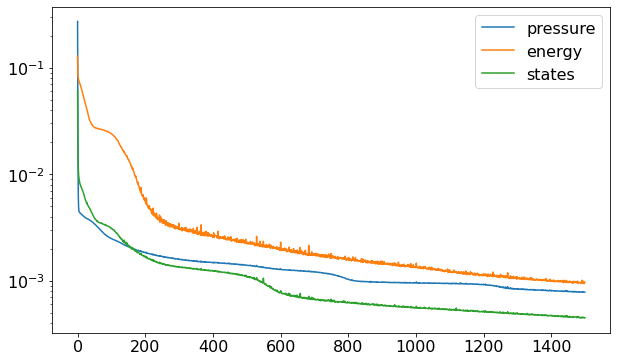

In [60]:
plt.semilogy(history.epoch,history.history['pressure_out_loss'], label='pressure')
plt.semilogy(history.epoch,history.history['energy_out_loss'], label='energy')
plt.semilogy(history.epoch,history.history['states_out_loss'], label='states')
plt.legend()

In [61]:
A_cluster = model.get_layer('pressure_out').get_weights()[0]

In [62]:
A_cluster

array([[-0.000e+00,  2.181e-02,  3.609e-02, ...,  9.029e-02, -0.000e+00, -0.000e+00],
       [ 3.612e-02,  2.074e-01,  3.367e-01, ...,  4.105e-01,  8.769e-05,  6.625e-05],
       [ 1.470e-01,  4.956e-03,  7.487e-03, ...,  3.189e-02,  5.533e-03,  5.720e-03],
       ...,
       [ 1.142e-01,  4.387e-02,  8.260e-02, ..., -0.000e+00,  1.129e-01,  1.127e-01],
       [ 2.458e-02,  1.122e-01,  1.819e-01, ...,  9.392e-02,  6.009e-02,  6.097e-02],
       [ 2.485e-03,  7.966e-02,  9.308e-02, ...,  1.334e-01,  1.942e-02,  2.021e-02]], dtype=float32)

In [64]:
np.sum(np.abs(A_cluster)<1e-6)

472

In [40]:
np.prod(A_cluster.shape)

11640

# Validation data

In [65]:
file = './validation/surrModel_scenarioDB_ruleBased_altControl2.pkl'
with open(file, 'rb') as f:
    validation = pickle.load(f)

In [66]:
output_names.keys()

dict_keys(['pressure', 'tanks', 'power'])

In [67]:
val_demand = validation['input'][input_names['demand']]
val_states = validation['input'][input_names['tanks']]
val_inputs = validation['input'][input_names['pumps']+input_names['valves']]

val_pressure = validation['output'][output_names['pressure']]
val_energy = validation['output'][output_names['power']]

<AxesSubplot:>

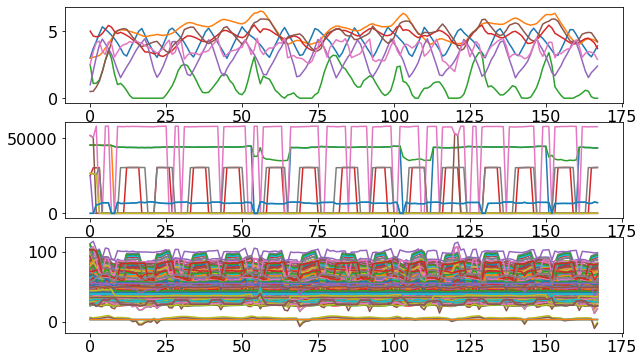

In [68]:
fig,ax = plt.subplots(3,1)
val_states.plot(ax=ax[0], legend=False)
val_energy.plot(ax=ax[1], legend=False)
val_pressure.plot(ax=ax[2], legend=False)

Text(0, 0.5, 'pump power ')

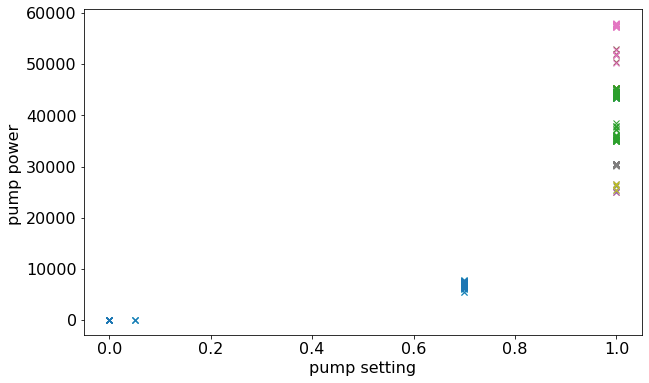

In [69]:
fig, ax = plt.subplots()
ax.plot(
    val_inputs[input_names['pumps']],
    val_energy[output_names['power']],
    'x'
)
ax.set_xlabel('pump setting')
ax.set_ylabel('pump power ')

### Simulation evaluation

In [70]:
from IPython.display import clear_output, display

In [71]:
val_demand_np = val_demand.to_numpy()
val_states_np = val_states.to_numpy()
val_inputs_np = val_inputs.to_numpy()

in_d_scaling = input_scaling['demand'].to_numpy()
in_s_scaling = input_scaling['states'].to_numpy()
in_i_scaling = input_scaling['inputs'].to_numpy()

out_p_scaling = output_scaling['pressure'].to_numpy()
out_e_scaling = output_scaling['energy'].to_numpy()
out_s_scaling = output_scaling['dstates'].to_numpy()

Open loop simulation of the Neural Network

In [73]:
est_states = [val_states_np[[0]]]
est_pressure = []
est_energy = []

for k in range(val_inputs_np.shape[0]-1):
    clear_output(wait=True)
    print(k)
    demand_k = val_demand_np[[k],:]
    states_k = est_states[k]
    inputs_k = val_inputs_np[[k],:]
    
    demand_k_scaled = demand_k/in_d_scaling
    states_k_scaled = states_k/in_s_scaling
    inputs_k_scaled = inputs_k/in_i_scaling

    pressure_scaled, energy_scaled, dstates_scaled = model.predict([demand_k_scaled, states_k_scaled, inputs_k_scaled])
    
    pressure_k = pressure_scaled * out_p_scaling
    energy_k = energy_scaled * out_e_scaling
    states_k_next = states_k + dstates_scaled * out_s_scaling
    states_k_next = dstates_scaled * out_s_scaling
    
    ### Achtung ENTFERNEN!!!!!!
    #states_k_next = val_states_np[[k+1]]
    #states_k_next = np.minimum(np.maximum(states_k_next,0),6)
    
    est_states.append(states_k_next)
    est_energy.append(energy_k)
    est_pressure.append(pressure_k)

est_pressure = np.concatenate(est_pressure,axis=0)
est_energy = np.concatenate(est_energy,axis=0)
est_states = np.concatenate(est_states,axis=0)

est_pressure_df = pd.DataFrame(data=est_pressure, index=val_pressure.index[:-1], columns=val_pressure.keys())
est_energy_df = pd.DataFrame(data=est_energy, index=val_energy.index[:-1], columns=val_energy.keys())
est_states_df = pd.DataFrame(data=est_states, index=val_states.index, columns=val_states.keys())

166


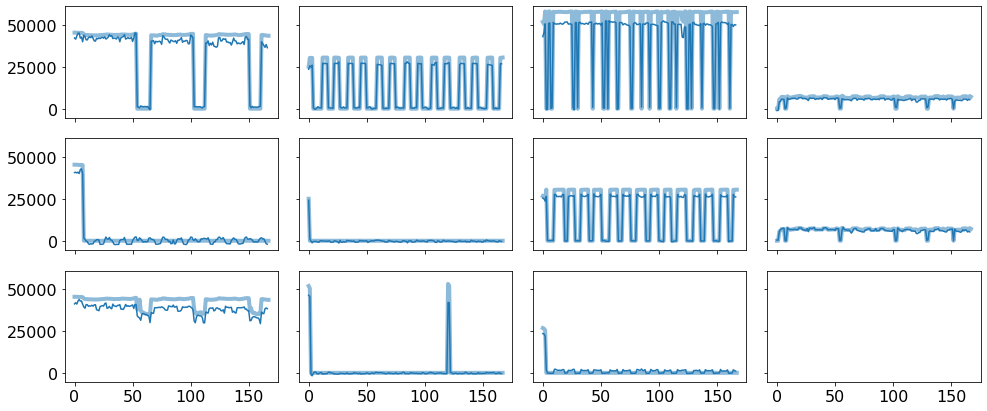

In [74]:
fig,ax = plt.subplots(3,4, figsize=(14,6), sharey=True, sharex=True)

for k,name in enumerate(val_energy.keys()):
    i,j = k%3,k//3
    
    val_energy[name].plot(legend=False, ax=ax[i,j],linewidth=4, alpha=.5)
    ax[i,j].set_prop_cycle(None)
    est_energy_df[name].plot(legend=False, ax=ax[i,j])

fig.tight_layout()
    

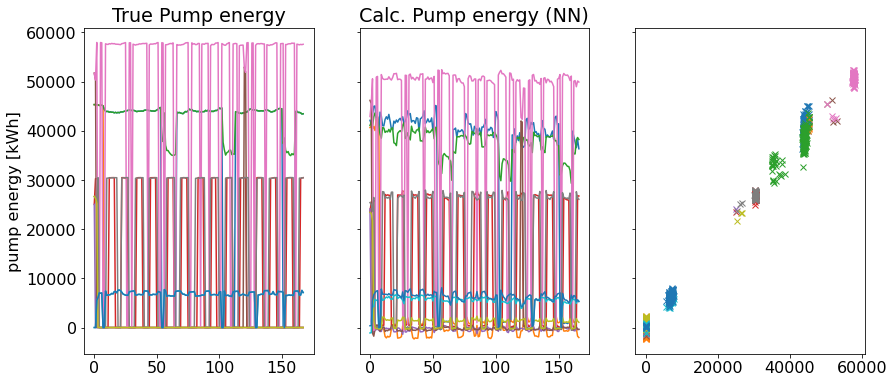

In [75]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_energy.plot(legend=False, ax=ax[0])
ax[1].plot(est_energy)
ax[0].set_title('True Pump energy')
ax[1].set_title('Calc. Pump energy (NN)')
ax[0].set_ylabel('pump energy [kWh]')

ax[2].plot(val_energy.to_numpy()[:-1,:], est_energy, 'x')

plt.show()

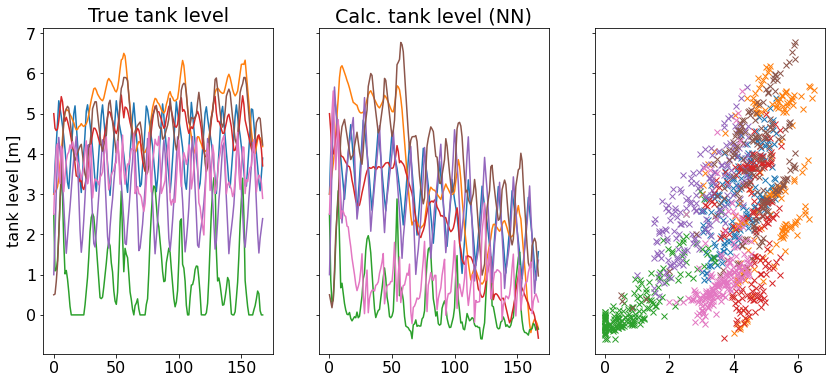

In [76]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_states.plot(legend=False, ax=ax[0])
ax[1].plot(est_states)
ax[0].set_title('True tank level')
ax[1].set_title('Calc. tank level (NN)')
ax[0].set_ylabel('tank level [m]')

ax[2].plot(val_states,est_states,'x')



plt.show()

In [77]:
est_states.shape

(168, 7)

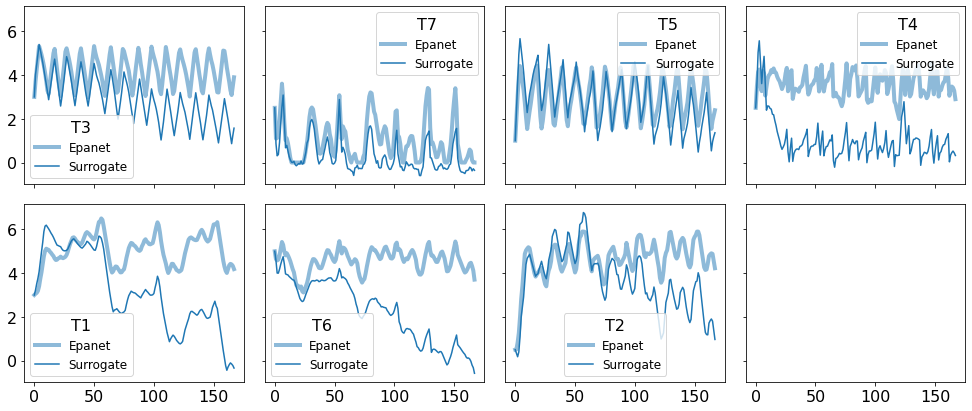

In [78]:
fig,ax = plt.subplots(2,4, figsize=(14,6), sharey=True, sharex=True)

for k,name in enumerate(val_states.keys()):
    i,j = k%2,k//2
    
    val_states[name].plot(ax=ax[i,j],linewidth=4, alpha=.5)
    ax[i,j].set_prop_cycle(None)
    est_states_df[name].plot(ax=ax[i,j])
    ax[i,j].legend(ax[i,j].lines,['Epanet','Surrogate'], title=name, fontsize=12)

fig.tight_layout()

In [79]:
ax[0,0].lines

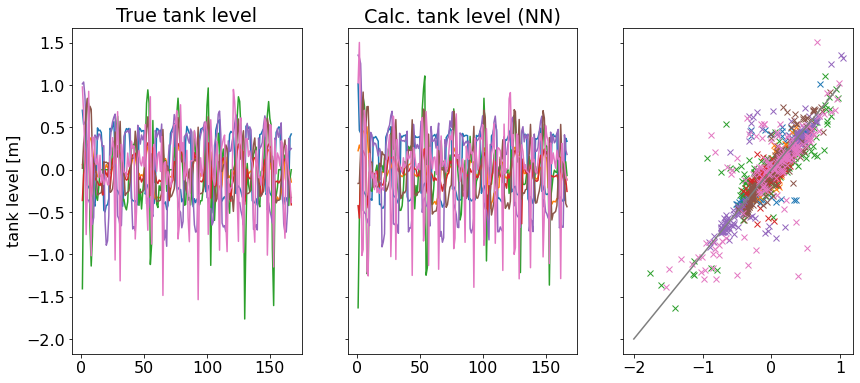

In [80]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_states.diff().plot(legend=False, ax=ax[0])
est_states_df.diff().plot(legend=False, ax=ax[1])
ax[0].set_title('True tank level')
ax[1].set_title('Calc. tank level (NN)')
ax[0].set_ylabel('tank level [m]')

ax[2].plot(val_states.diff(), est_states_df.diff(),'x')
ax[2].plot([-2,1],[-2,1])

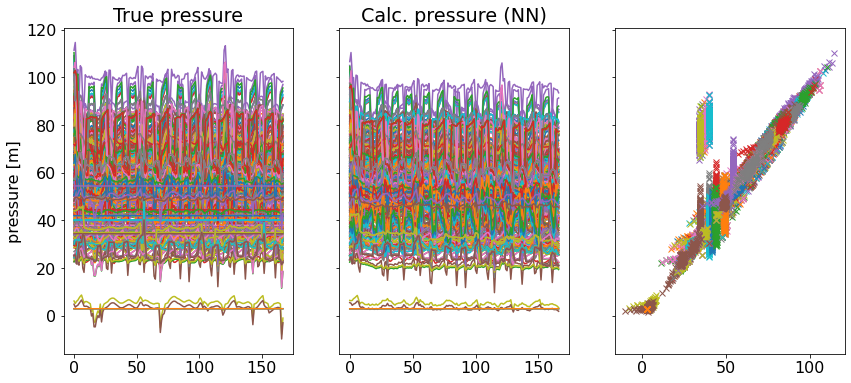

In [81]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_pressure.plot(legend=False, ax=ax[0])
ax[1].plot(est_pressure)
ax[0].set_title('True pressure')
ax[1].set_title('Calc. pressure (NN)')
ax[0].set_ylabel('pressure [m]')
ax[2].plot(val_pressure.to_numpy()[:-1,:],est_pressure, 'x')
plt.show()

Should we save the model?

In [82]:
model_name = '004'
model.save('./keras_models/{name}/{name}_model'.format(name=model_name))
scaling = {
    'input': input_scaling,
    'output': output_scaling
}

with open('./keras_models/{}/scaling.pkl'.format(model_name), 'wb') as f:
    pickle.dump(scaling, f)
    
history_export = history.history
history_export['epoch'] = history.epoch

with open('./keras_models/{}/history.pkl'.format(model_name), 'wb') as f:
    pickle.dump(history_export, f)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./keras_models/004/004_model/assets
